In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import torch
import h5py

import time

##### Constants

In [24]:
h = 6.6260755e-27 # erg s
hbar = h/(2.*np.pi) # erg s
c = 2.99792458e10 # cm/s
MeV = 1.60218e-6 # erg
eV = MeV/1e6 # erg
GF_GeV2 = 1.1663787e-5 # GeV^-2
GF = GF_GeV2 / (1000*MeV)**2 * (hbar*c)**3 # erg cm^3
Mp = 1.6726219e-24 # g

### NSM simulation snapshot

In [25]:
input_filename = "/nucastro3/jfroust/M1-NuLib/model_rl1_orthonormal.h5"

file = h5py.File(input_filename,'r')

#print(file.keys())

# Eddington factors
chi_a = file["eddfac_a(1|ccm)"][()]
chi_e = file["eddfac_e(1|ccm)"][()]
chi_x = file["eddfac_x(1|ccm)"][()]

# Crossing or not?
Delta = file["crossing_discriminant"][()]
Delta_scaled = np.heaviside(Delta, 0.)

# Temperature
T_array = file["T(MeV)"][()]

# Number densities
nue = file["n_e(1|ccm)"][()]
nuebar = file["n_a(1|ccm)"][()]
nux = file["n_x(1|ccm)"][()]

# Energy densities
J_e = file["J_e(erg|ccm)"][()]
J_ebar = file["J_a(erg|ccm)"][()]
J_x = file["J_x(erg|ccm)"][()]

E_e = J_e/nue/MeV #MeV
E_ebar = J_ebar/nuebar/MeV #MeV
E_x = J_x/nux/MeV #MeV

# Matter density
rho = file["rho(g|ccm)"][()]
Ye = file['Ye'][()]

# Flux factors
fee = file["fluxfac_e(1|ccm)"][()]
feebar = file["fluxfac_a(1|ccm)"][()]
fxx = file["fluxfac_x(1|ccm)"][()]
# They are such that fee[i,j,k] = np.linalg.norm(fnee[:,i,j,k]/nue[i,j,k])

# Fluxes, shape (3,nx,ny,nz)
fnee = file["fn_e(1|ccm)"][()]
fneebar = file["fn_a(1|ccm)"][()]
fnxx = file["fn_x(1|ccm)"][()]

x = file["x(cm)"][()]*1e-5 #(km)
y = file["y(cm)"][()]*1e-5 #(km)
z = file["z(cm)"][()]*1e-5 #(km)

#Collision rates
#Coll_nue = file["nue_absrate(1|s)"][()]
#Coll_nua = file["anue_absrate(1|s)"][()]

file.close()

### ML model output

In [26]:
def get_output(outfile):
    output_tensor = torch.jit.load(outfile)
    F4_in = list(output_tensor.parameters())[0]
    F4_out = list(output_tensor.parameters())[1]
    
    F4_in = F4_in.numpy().reshape(256,256,4,2,3)
    F4_out = F4_out.detach().numpy().reshape(256,256,4,2,3)

    # Neutrinos
    Nee_in = F4_in[:,:,3,0,0]
    Nmumu_in = F4_in[:,:,3,0,1]
    Ntautau_in = F4_in[:,:,3,0,2]
    Nxx_in = (Nmumu_in + Ntautau_in)/2
    TrN_in = Nee_in + Nmumu_in + Ntautau_in

    Fee_in = F4_in[:,:,0:3,0,0]
    Fmumu_in = F4_in[:,:,0:3,0,1]
    Ftautau_in = F4_in[:,:,0:3,0,2]

    Nee_out = F4_out[:,:,3,0,0]
    Nmumu_out = F4_out[:,:,3,0,1]
    Ntautau_out = F4_out[:,:,3,0,2]
    Nxx_out = (Nmumu_out + Ntautau_out)/2
    TrN_out = Nee_out + Nmumu_out + Ntautau_out

    Fee_out = F4_out[:,:,0:3,0,0]
    Fmumu_out = F4_out[:,:,0:3,0,1]
    Ftautau_out = F4_out[:,:,0:3,0,2]

    # Antineutrinos
    Neebar_in = F4_in[:,:,3,1,0]
    Nmumubar_in = F4_in[:,:,3,1,1]
    Ntautaubar_in = F4_in[:,:,3,1,2]
    Nxxbar_in = (Nmumubar_in + Ntautaubar_in)/2
    TrNbar_in = Neebar_in + Nmumubar_in + Ntautaubar_in

    Feebar_in = F4_in[:,:,0:3,1,0]
    Fmumubar_in = F4_in[:,:,0:3,1,1]
    Ftautaubar_in = F4_in[:,:,0:3,1,2]

    Neebar_out = F4_out[:,:,3,1,0]
    Nmumubar_out = F4_out[:,:,3,1,1]
    Ntautaubar_out = F4_out[:,:,3,1,2]
    Nxxbar_out = (Nmumubar_out + Ntautaubar_out)/2
    TrNbar_out = Neebar_out + Nmumubar_out + Ntautaubar_out

    Feebar_out = F4_out[:,:,0:3,1,0]
    Fmumubar_out = F4_out[:,:,0:3,1,1]
    Ftautaubar_out = F4_out[:,:,0:3,1,2]
    
    return(Nee_in,Nmumu_in,Ntautau_in,Nxx_in,TrN_in,Fee_in,Fmumu_in,Ftautau_in,Nee_out,Nmumu_out,
                   Ntautau_out,Nxx_out,TrN_out,Fee_out,Fmumu_out,Ftautau_out,
          Neebar_in,Nmumubar_in,Ntautaubar_in,Nxxbar_in,TrNbar_in,Feebar_in,Fmumubar_in,Ftautaubar_in,Neebar_out,Nmumubar_out,
                   Ntautaubar_out,Nxxbar_out,TrNbar_out,Feebar_out,Fmumubar_out,Ftautaubar_out)

In [27]:
def cutoff(outfile,threshold):
    output_tensor = torch.jit.load(outfile)
    F4_in = list(output_tensor.parameters())[0]
    F4_out = list(output_tensor.parameters())[1]
    
    F4_in = F4_in.numpy().reshape(256,256,4,2,3)
    F4_out = F4_out.detach().numpy().reshape(256,256,4,2,3)
    
    TrN_in = np.sum(F4_in[:,:,3,:,:],axis=3)
    TrN_out = np.sum(F4_out[:,:,3,:,:],axis=3)
    Diff = (F4_out-F4_in)/TrN_in[:,:,np.newaxis,:,np.newaxis]
    
    #F4_out = np.where(np.abs(Diff)>threshold,F4_out,F4_in)
    F4_out = np.where(np.max(np.abs(Diff),axis=(2,3,4))[:,:,np.newaxis,np.newaxis,np.newaxis]>threshold,
                      F4_out,F4_in)
    
    #for i in range(201):
    #    for k in range(101):
    #        for n in range(4):
    #            for anti in range(2):
    #                for flav in range(3):
    #                    if np.abs(Diff[i,k,n,anti,flav]) <= threshold:
    #                        F4_out[i,k,n,anti,flav] = F4_in[i,k,n,anti,flav]
    
    Nee_in = F4_in[:,:,3,0,0]
    Nmumu_in = F4_in[:,:,3,0,1]
    Ntautau_in = F4_in[:,:,3,0,2]
    Nxx_in = (Nmumu_in + Ntautau_in)/2
    TrN_in = Nee_in + Nmumu_in + Ntautau_in

    Fee_in = F4_in[:,:,0:3,0,0]
    Fmumu_in = F4_in[:,:,0:3,0,1]
    Ftautau_in = F4_in[:,:,0:3,0,2]

    Nee_out = F4_out[:,:,3,0,0]
    Nmumu_out = F4_out[:,:,3,0,1]
    Ntautau_out = F4_out[:,:,3,0,2]
    Nxx_out = (Nmumu_out + Ntautau_out)/2
    TrN_out = Nee_out + Nmumu_out + Ntautau_out

    Fee_out = F4_out[:,:,0:3,0,0]
    Fmumu_out = F4_out[:,:,0:3,0,1]
    Ftautau_out = F4_out[:,:,0:3,0,2]
    
    return(Nee_in,Nmumu_in,Ntautau_in,Nxx_in,TrN_in,Fee_in,Fmumu_in,Ftautau_in,Nee_out,Nmumu_out,
                   Ntautau_out,Nxx_out,TrN_out,Fee_out,Fmumu_out,Ftautau_out)

In [28]:
output_tensor = torch.jit.load("../build/tensor_rl1_y129.pt")
F4_in = list(output_tensor.parameters())[0]
F4_out = list(output_tensor.parameters())[1]
    
F4_in = F4_in.numpy().reshape(256,256,4,2,3)
F4_out = F4_out.detach().numpy().reshape(256,256,4,2,3)
    
TrN_in = np.sum(F4_in[:,:,3,:,:],axis=3)
TrN_out = np.sum(F4_out[:,:,3,:,:],axis=3)
Diff = (F4_out-F4_in)/TrN_in[:,:,np.newaxis,:,np.newaxis]

## Plots

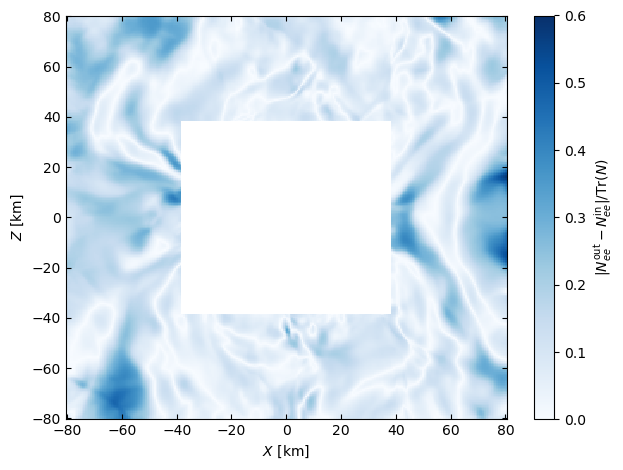

In [38]:
resname = "rl1_y129_nomask"

(Nee_in,Nmumu_in,Ntautau_in,Nxx_in,TrN_in,Fee_in,Fmumu_in,Ftautau_in,Nee_out,Nmumu_out,Ntautau_out,Nxx_out,TrN_out,Fee_out,Fmumu_out,Ftautau_out,
Neebar_in,Nmumubar_in,Ntautaubar_in,Nxxbar_in,TrNbar_in,Feebar_in,Fmumubar_in,Ftautaubar_in,Neebar_out,Nmumubar_out,Ntautaubar_out,
Nxxbar_out,TrNbar_out,Feebar_out,Fmumubar_out,Ftautaubar_out) = get_output(
"../build/tensor_"+resname+".pt")

delta_Nee = (Nee_out - Nee_in)/TrN_in
delta_DN = (Nee_out - Nxx_out - Nee_in + Nxx_in)/TrN_in
delta_Nee_bis = (Nee_out - Nee_in)/(Nee_in+Nee_out)
delta_Neebar = (Neebar_out - Neebar_in)/TrNbar_in
delta_DNbar = (Neebar_out - Nxxbar_out - Neebar_in + Nxxbar_in)/TrNbar_in
delta_Neebar_bis = (Neebar_out - Neebar_in)/(Neebar_in+Neebar_out)

#plt.pcolormesh(x[:,:,0],y[:,:,0],np.abs(delta_Nee),vmin=0, vmax=0.6,cmap="Blues")
plt.pcolormesh(x[:,0,:],z[:,0,:],np.abs(delta_Nee),vmin=0, vmax=0.6,cmap="Blues")
#plt.ylabel(r'$Y \ [\mathrm{km}]$')
plt.ylabel(r'$Z \ [\mathrm{km}]$')
plt.xlabel(r'$X \ [\mathrm{km}]$')
plt.colorbar(label=r'$|N_{ee}^\mathrm{out}-N_{ee}^\mathrm{in}|/\mathrm{Tr}(N)$')

plt.tick_params(axis='both', direction='in',top='True',right='True')
plt.tight_layout()
plt.savefig(resname+"_delta_Nee.png",dpi=500)

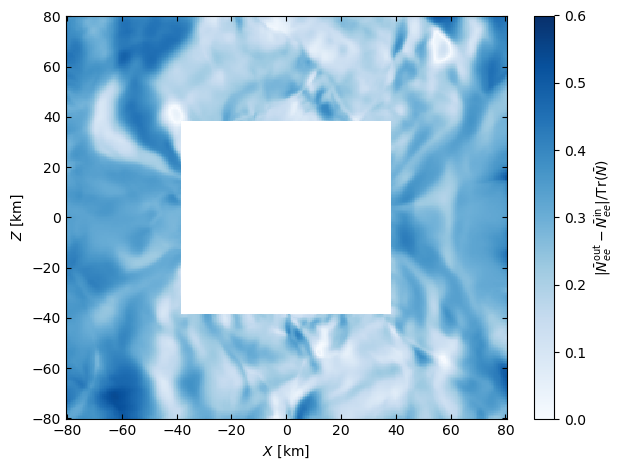

In [39]:
#plt.pcolormesh(x[:,:,0],y[:,:,0],np.abs(delta_Neebar),vmin=0, vmax=0.6,cmap="Blues")
plt.pcolormesh(x[:,0,:],z[:,0,:],np.abs(delta_Neebar),vmin=0, vmax=0.6,cmap="Blues")
#plt.ylabel(r'$Y \ [\mathrm{km}]$')
plt.ylabel(r'$Z \ [\mathrm{km}]$')
plt.xlabel(r'$X \ [\mathrm{km}]$')
plt.colorbar(label=r'$|\bar{N}_{ee}^\mathrm{out}-\bar{N}_{ee}^\mathrm{in}|/\mathrm{Tr}(\bar{N})$')

plt.tick_params(axis='both', direction='in',top='True',right='True')
plt.tight_layout()
plt.savefig(resname+"_delta_Neebar.png",dpi=500)

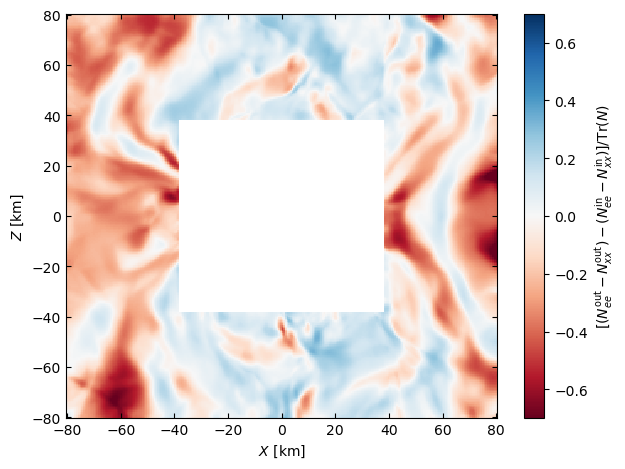

In [40]:
#plt.pcolormesh(x[:,:,0],y[:,:,0],delta_DN,vmin=-0.7, vmax=0.7,cmap="RdBu")
plt.pcolormesh(x[:,0,:],z[:,0,:],delta_DN,vmin=-0.7, vmax=0.7,cmap="RdBu")
#plt.ylabel(r'$Y \ [\mathrm{km}]$')
plt.ylabel(r'$Z \ [\mathrm{km}]$')
plt.xlabel(r'$X \ [\mathrm{km}]$')
plt.colorbar(label=r'$[(N_{ee}^\mathrm{out}-N_{xx}^\mathrm{out})-(N_{ee}^\mathrm{in}-N_{xx}^\mathrm{in})]/\mathrm{Tr}(N)$')

plt.tick_params(axis='both', direction='in',top='True',right='True')
plt.tight_layout()
plt.savefig(resname+"_delta_DN.png",dpi=500)

In [41]:
## Checking the flux factors

fee_in=np.sqrt(np.sum((Fee_in/Nee_in[:,:,np.newaxis])**2,axis=2))
#Careful, the arrays from torch are in float32 -> limited range of numbers an precision
fee_out=np.sqrt(np.sum((Fee_out/Nee_out[:,:,np.newaxis])**2,axis=2))
fmumu_out=np.sqrt(np.sum((Fmumu_out/Nmumu_out[:,:,np.newaxis])**2,axis=2))
ftautau_out=np.sqrt(np.sum((Ftautau_out/Ntautau_out[:,:,np.newaxis])**2,axis=2))
feebar_out=np.sqrt(np.sum((Feebar_out/Neebar_out[:,:,np.newaxis])**2,axis=2))
fmumubar_out=np.sqrt(np.sum((Fmumubar_out/Nmumubar_out[:,:,np.newaxis])**2,axis=2))
ftautaubar_out=np.sqrt(np.sum((Ftautaubar_out/Ntautaubar_out[:,:,np.newaxis])**2,axis=2))

In [42]:
print("Max flux factors:","nu_e",np.nanmax(fee_out),"| nu_x",np.nanmax(ftautau_out))
print("Minimum number densities (1|ccm):","nu_e",np.nanmin(Nee_out),"| nu_x", np.nanmin(Nmumu_out))

Max flux factors: nu_e 0.99693006 | nu_x 0.9973462
Minimum number densities (1|ccm): nu_e 4.0443332e+30 | nu_x 3.4487456e+30


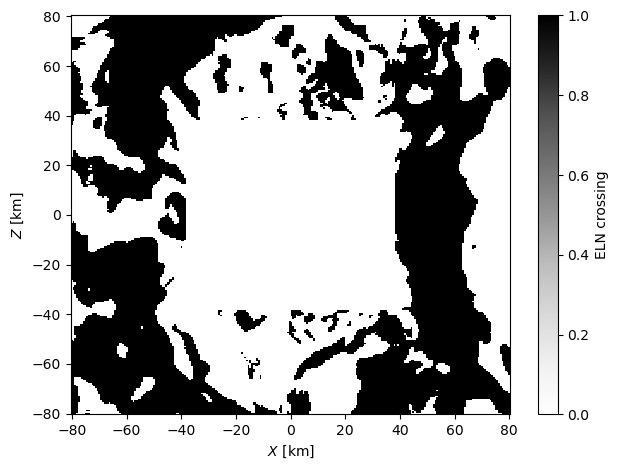

In [43]:
#plt.pcolormesh(x[:,:,0],y[:,:,0],Delta_scaled[:,:,129],vmin=0,vmax=1,cmap="Greys")
plt.pcolormesh(x[:,0,:],z[:,0,:],Delta_scaled[:,129,:],vmin=0,vmax=1,cmap="Greys")
plt.xlabel(r'$X \ [\mathrm{km}]$')
#plt.ylabel(r'$Y \ [\mathrm{km}]$')
plt.ylabel(r'$Z \ [\mathrm{km}]$')
plt.colorbar(label="ELN crossing")
plt.tight_layout()
plt.savefig(resname+"_ELNcrossing.png",dpi=500)

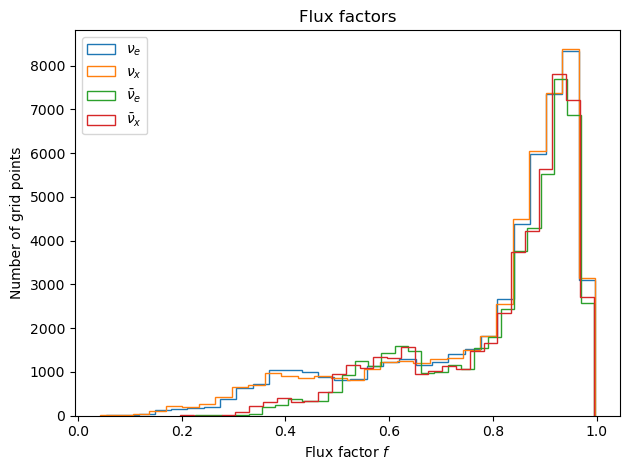

In [44]:
plt.hist(np.ndarray.flatten(fee_out),bins=30,label=r'$\nu_e$',histtype='step')
plt.hist(np.ndarray.flatten(fmumu_out),bins=30,label=r'$\nu_x$',histtype='step')
plt.hist(np.ndarray.flatten(feebar_out),bins=30,label=r'$\bar{\nu}_e$',histtype='step')
plt.hist(np.ndarray.flatten(fmumubar_out),bins=30,label=r'$\bar{\nu}_x$',histtype='step')
plt.xlabel(r'$\mathrm{Flux \ factor \ } f$')
plt.ylabel("Number of grid points")
plt.title('Flux factors')
plt.legend()
plt.tight_layout()
plt.savefig(resname+"_flux_factors.pdf")

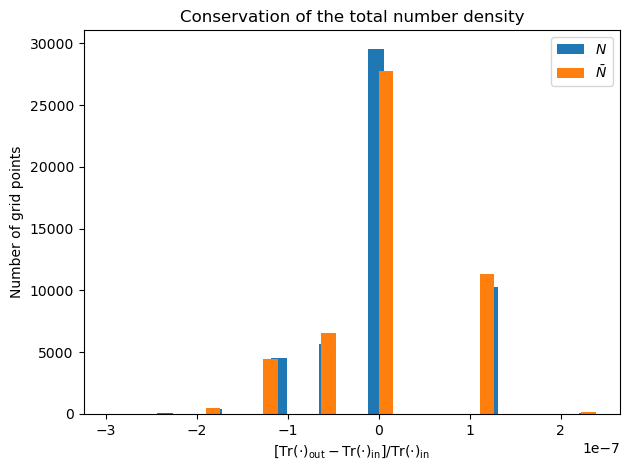

In [45]:
plt.hist(np.ndarray.flatten(TrN_out/TrN_in-1),30,label=r'$N$')#,histtype='barstacked')
plt.hist(np.ndarray.flatten(TrNbar_out/TrNbar_in-1),30,label=r'$\bar{N}$')#,histtype='barstacked')
plt.title("Conservation of the total number density")
plt.ylabel("Number of grid points")
plt.xlabel(r'$[\mathrm{Tr}(\cdot)_\mathrm{out}-\mathrm{Tr}(\cdot)_\mathrm{in}]/\mathrm{Tr}(\cdot)_\mathrm{in}$')
plt.legend()
plt.tight_layout()
plt.savefig(resname+"_TrN.pdf")

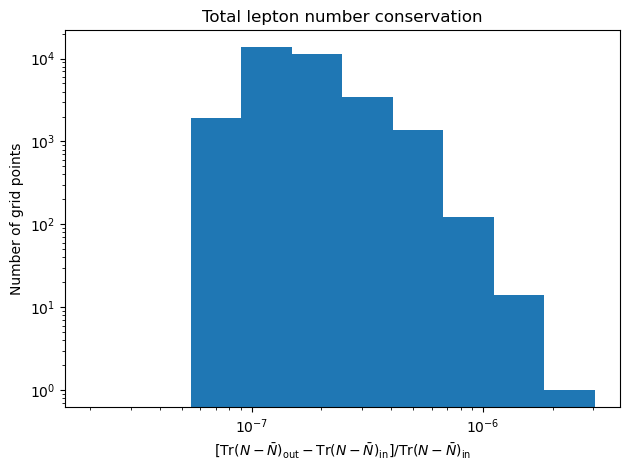

In [46]:
def plot_loghist(x, bins):
    hist, bins = np.histogram(x, bins=bins,range=(np.nanmin(x),np.nanmax(x)))
    logbins = np.logspace(np.log10(bins[0]+2e-8),np.log10(bins[-1]),len(bins))
    plt.hist(x, bins=logbins,log=True)
    plt.xscale('log')
    
#plt.hist(np.ndarray.flatten(np.abs((TrN_out-TrNbar_out)/(TrN_in-TrNbar_in)-1)),log=True,histtype='step')
plot_loghist(np.ndarray.flatten(np.abs((TrN_out-TrNbar_out)/(TrN_in-TrNbar_in)-1)), 10)
plt.title("Total lepton number conservation")
plt.ylabel("Number of grid points")
plt.xlabel(r'$[\mathrm{Tr}(N-\bar{N})_\mathrm{out}-\mathrm{Tr}(N-\bar{N})_\mathrm{in}]/\mathrm{Tr}(N-\bar{N})_\mathrm{in}$')
plt.tight_layout()
plt.savefig(resname+"_total_LN.pdf")